## 获取数据

In [1]:
# 导入mxnet
import mxnet as mx

# 设置随机种子
mx.random.seed(2)

from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd


# 数据预处理
def transform(data, label):
    return data.astype('float32') / 255, label.astype('float32')

# 加载训练数据
mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)

# 加载测试数据
mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

In [2]:
# 取出单条数据
data, label = mnist_train[0]

# 查看数据
('example shape: ', data.shape, 'label:', label)

('example shape: ', (28L, 28L, 1L), 'label:', 2.0)

## 数据可视化

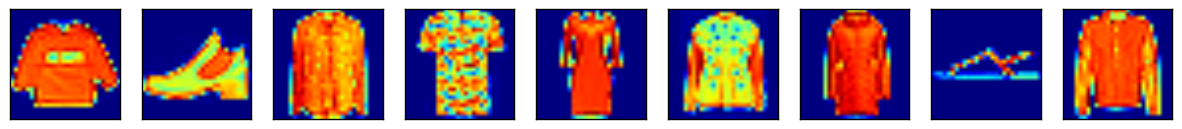

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress,', 'coat', 'coat', 'sandal', 'coat']


In [3]:
import matplotlib.pyplot as plt

# 显示图像
def show_images(images):
    # 获得图像的数量
    n = images.shape[0]
    # 绘制子图
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    # 遍历绘制图像
    for i in xrange(n):
        # 显示图像
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        
        # 显示灰度图
        #figs[i].imshow(images[i].reshape((28, 28)).asnumpy(), cmap="gray")
        
        # 不显示坐标轴
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()
    
# 获取图像对应的文本标签
def get_text_labels(labels):
    # 图像标签对应的文本
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    # 返回图像标签对应的文本
    return [text_labels[int(i)] for i in labels]

# 取出训练集的前9条数据
data, label = mnist_train[0:9]

# 显示数据
show_images(data)
# 显示标签
print get_text_labels(label)

## 数据读取

In [4]:
# 批数据大小
batch_size = 256

# 读取训练数据
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
# 读取测试数据
test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

## 初始化模型参数

In [5]:
# 输入数据大小
num_inputs = 28 * 28
# 输出数据大小, 分为10类
num_outputs = 10

# 随机初始化权重
W = nd.random_normal(shape=(num_inputs, num_outputs))
# 随机初始化偏置
b = nd.random_normal(shape=num_outputs)

# 参数数组
params = [W, b]

In [6]:
# 需要计算梯度, 添加自动求导
for param in params:
    param.attach_grad()

## 定义模型

In [7]:
# 定义softmax
def softmax(X):
    # 计算e^x
    exp = nd.exp(X)
    # 假设exp是矩阵，这里对行进行求和，并要求保留axis 1, 就是返回 (nrows, 1) 形状的矩阵
    partition = exp.sum(axis=1, keepdims=True)
    # 对exp进行归一化
    return exp / partition

In [8]:
# 测试softmax

# 随机初始化数据
X = nd.random_normal(shape=(2, 5))
# 求softmax
X_prob = softmax(X)
# 输出结果
print X_prob
# 对每行概率求和, 如果和为1, 说明没问题
print X_prob.sum(axis=1)


[[ 0.06774449  0.5180918   0.1474141   0.11459844  0.1521512 ]
 [ 0.23102701  0.47666225  0.10536087  0.09706162  0.08988826]]
<NDArray 2x5 @cpu(0)>

[ 1.  1.]
<NDArray 2 @cpu(0)>


In [9]:
# 定义模型
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## 交叉熵损失函数

In [10]:
# 定义交叉熵损失
def cross_entropy(yhat, y):
    return -nd.pick(nd.log(yhat), y)

## 计算精度

In [11]:
# 计算分类准确率
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1) == label).asscalar()

In [12]:
# 评估整个数据集的分类精度
def evaluate_accuracy(data_iterator, net):
    # 最终的准确率
    acc = 0.0
    # 遍历测试数据集
    for data, label in data_iterator:
        output = net(data)
        # 累加准确率
        acc += accuracy(output, label)
    # 返回平均准确率
    return acc / len(data_iterator)

In [13]:
# 测试随机初始化参数的分类准确率
evaluate_accuracy(test_data, net)

0.15156249999999999

## 训练

In [14]:
# 定义SGD
def SGD(params, lr):
    # 对参数进行梯度下降
    for param in params:
        # 这样写不会创建新的param, 而是会写在原来的param里, 新的param没有梯度
        param[:] = param - lr * param.grad

In [15]:
# 学习率
learning_rate = 0.1

# 定义迭代周期
epochs = 5

# 训练
for epoch in range(5):
    # 训练损失
    train_loss = 0.0
    # 训练集准确率
    train_acc = 0.0
    # 迭代巡礼
    for data, label in train_data:
        # 记录梯度
        with autograd.record():
            # 计算输出
            output = net(data)
            # 计算损失
            loss = cross_entropy(output, label)
        # 反向传播求梯度
        loss.backward()
        # 将梯度做平均，这样学习率会对batch size不那么敏感, 避免学习率与batch_size耦合
        SGD(params, learning_rate / batch_size)
        # 总的训练损失
        train_loss += nd.mean(loss).asscalar()
        # 总的训练准确率
        train_acc += accuracy(output, label)
    
    # 测试集的准确率
    test_acc = evaluate_accuracy(test_data, net)
    
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
        epoch, train_loss / len(train_data), train_acc / len(train_data), test_acc))

Epoch 0. Loss: 3.725043, Train acc 0.487916, Test acc 0.602344
Epoch 1. Loss: 1.965692, Train acc 0.632812, Test acc 0.666895
Epoch 2. Loss: 1.630362, Train acc 0.677349, Test acc 0.691016
Epoch 3. Loss: 1.450728, Train acc 0.701690, Test acc 0.710352
Epoch 4. Loss: 1.329035, Train acc 0.717996, Test acc 0.720410


## 预测

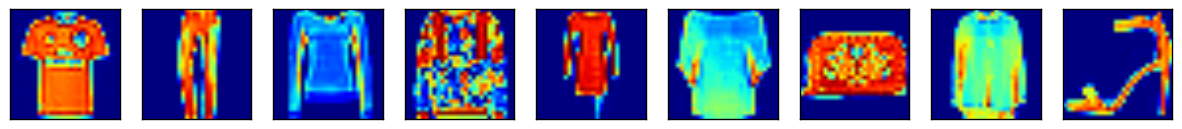

True labels: 
['t-shirt', 'trouser', 'pullover', 'pullover', 'dress,', 'pullover', 'bag', 'shirt', 'sandal']
Predicted labels: 
['shirt', 'trouser', 'pullover', 'pullover', 'dress,', 'bag', 'bag', 'shirt', 'sandal']


In [16]:
# 从测试集中取数据
data, label = mnist_test[0:9]
# 显示图片及真实标签
show_images(data)
print 'True labels: '
print get_text_labels(label)


# 预测标签
predicted_labels = net(data).argmax(axis=1)
print 'Predicted labels: '
print get_text_labels(predicted_labels.asnumpy())


## 参考资料

* FashionMNIST  
[https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/vision.html#FashionMNIST](https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/vision.html#FashionMNIST)  

